# Задание

Анализ изображений классическими методами компьютерного зрения:

1) 
2) Найти полосы движения на изображении `./images/road1.png` и точку схода этих прямых. 
3) По изображению `./images/src_ball.jpg` получить “вид сверху”, найти шары и кий, оценить направление удара и траекторию прицельного шара после удара.

# Настройки/Импорты

In [1]:
import cv2 # для работы с изображениями
import numpy as np # для работы с массивами
from matplotlib import pyplot as plt # для построения графиков/вывода изображений

# Вспомогательные функции

In [2]:
def show_image(image, figsize: tuple, gray: bool=False) -> None:
    """
    Функция для вывода изображений.\n
    Parameters:
        * image: изображение, что нужно вывести
        * figsize: размер выводимой картинки
        * gray: флаг, является ли изображение одноканальным (чёрно-белым)\n
    Returns:
        * None
    """
    cmap = "gray" if gray else "viridis" # выбор цветовой схемы, (стандартная — "viridis", но если передан ключ gray — "gray")

    plt.figure(figsize=figsize) # размер фигуры
    plt.imshow(image, cmap) # вывод изображения
    plt.show() # показ фигуры

In [3]:
def find_intersection(line1: list, line2: list) -> np.array:
    """Функция для поиска точки пересечения прямых.\n
    Parameters:
        * line1: первая прямая, заданная двумя точками в формате [x1, y1, x2, y2] 
        * line2: вторая прямая, заданная двумя точками в формате [x3, y3, x4, y4]\n
    Returns:
        * np.array: целые координаты точки пересечения в формате [x, y]
    """
    x1, y1, x2, y2 = line1 # берём координаты точек на первой прямой
    x3, y3, x4, y4 = line2 # берём координаты точек на второй прямой
    px= ( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ) # считаем точку пересечения по x
    py= ( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ) # считаем точку пересечения по y
    return np.array([px, py], dtype=np.int32) # возвращаем целые координаты точки пересечения

In [4]:
def movement(point: list, vx, vy, xmax, ymax, borders: list=[]) -> np.array:
    """
    Функция для простого оценивания перемещения точки при воздействии на неё сил.\n
    Parameters:
        * point: изначальные координаты точки в формате [x, y] 
        * vx: скорость изменения положения точки по оси OX в пикселях за один момент
        * vy: скорость изменения положения точки по оси OY в пикселях за один момент
        * xmax: максимальное значение для оси OX (можно брать .shape[1] изображения, так как у него сначала идёт высота высота, а потом ширина (важно не ошибиться!))
        * ymax: максимальное значение для оси OY (можно брать .shape[0] изображения, так как у него сначала идёт высота высота, а потом ширина (важно не ошибиться!))
        * borders: дополнительные границы, которые точка пройти не может (останавливается при косании)\n
    Returns:
        * list: новые целые координаты точки после воздействия на неё в формате [x, y]
    """
    x_new, y_new = point[0], point[1] # берём изначальные данные о положении точки
    while ([int(x_new), int(y_new)] not in borders) and (0 < x_new < xmax) and (0 < y_new < ymax): # цикл, пока не наткнёмся на границу, будь то заданная пользователем или самим изображенимем
        x = x_new # запоминаем значение с предыдущего шага
        y = y_new # запоминаем значение с предыдущего шага
        x_new = x + vx # перемещаем центр по оси OX
        y_new = y + vy # перемещаем центр по оси OY
    return np.array([x, y], dtype=np.int32) # возвращаем значения, что были ещё в допустимой области

In [5]:
def line_equation(pt1, pt2) -> list:
    """Функция для получения уравнения прямой y=a*x+b по двум точкам.\n
    Parameters:
        * pt1: координаты первой точки в виде [x1, y1]
        * pt1: координаты второй точки в виде [x2, y2]\n
    Returns:
        * list: коэффициенты [a, b] в уравнении прямой y=a*x+b
    """
    x1, y1 = pt1 # взятие координат точки 1
    x2, y2 = pt2 # взятие координат точки 2
    a = (y1 -y2)/(x1-x2) # считаем коэффициент a из следующих уравнений: y1=a*x1+b, y2=a*x2+b => (вычитаем друг из друга) y1-y2=a(x1-x2) => a=(y1 -y2)/(x1-x2)
    b = y1 - a * x1 # находи смещением b простым подставлением известных данных: y1=a*x1+b => b=y1-a*x1
    return [a, b]

In [6]:
def get_line_point(x, a, b) -> list:
    """Функция для получения точки на прямой.\n
    Parameters:
        * x: значение по x
        * a: коэффициент 'a' в уравнении прямой y=a*x+b
        * b: смещение 'b' в уравнении прямой y=a*x+b\n
    Returns:
        * float: точка [x, y] на заданной прямой
    """
    y = a * x + b # считаем точку y на прямой по входным данным
    return [x, y]

# 1)

# 2) Найти полосы движения на изображении `./images/road1.png` и точку схода этих прямых. 

## Загрузка изображения

In [7]:
img_bgr = cv2.imread('./images/road1.png') # загружаем изображение
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # конвертируем в другую цветовую схему (изначально картинка в формате BGR)
img_rgb.shape # размерность изображения (height, width, colors)

(590, 1178, 3)

Original shape: (590, 1178, 3)


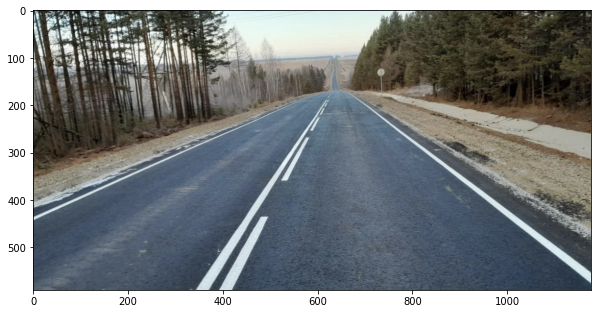

In [8]:
print(f"Original shape: {img_rgb.shape}") # вывод размерности
show_image(image=img_rgb, figsize=(10, 20)) # вывод изображения

## Преобразования над изображением

Конвертируем изображение в чёрно-белый формат, так как в нём находятся более чёткие линии.

Grayscale shape: (590, 1178)


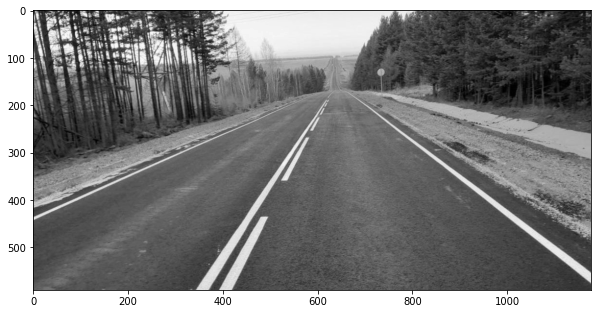

In [9]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) # конвертируем из RGB в чёрно-белую цветовую схему (cv2.COLOR_RGB2GRAY)
print(f"Grayscale shape: {img_gray.shape}") # вывод размерности
show_image(image=img_gray, figsize=(10, 20), gray=True) # вывод изображения

Добавляем размытие чтобы сгладить нечёткие места => градиенты уменьшаться => будет найдено меньше линий в алгоритме Кэнни (нахождения границ объектов на изображении).

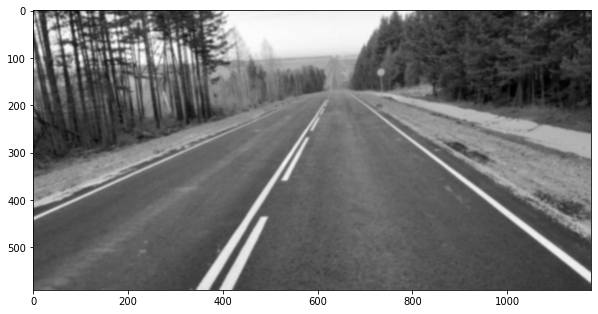

In [10]:
img_gray_blur = cv2.GaussianBlur(img_gray, ksize=(9, 9), sigmaX=0) # добавляем размытие на изображение (ksize — размер ядра в пикселях, sigmaX — стандартное отклонение для ядра Гаусса (дублируется в sigmaY))
show_image(image=img_gray_blur, figsize=(10, 20), gray=True) # вывод изображения

## Поиск основной полосы движения

Ищем границы объектов.

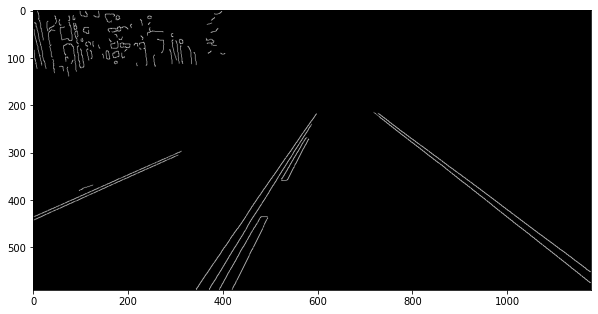

In [11]:
edges_gray_blur = cv2.Canny(img_gray_blur, threshold1=200, threshold2=300) # запускаем алгоритм Кэнни поиска границ объектов (threshold1 и threshold2 — пороги для алгоритма)
show_image(image=edges_gray_blur, figsize=(10, 20), gray=True) # вывод изображения

Пример того, что бы было при обычном RGB изображении, без проведённых преобразований (чёрно-белая картинка + блюр).

In [12]:
edges_rgb = cv2.Canny(img_rgb, threshold1=200, threshold2=300) # запускаем алгоритм Кэнни поиска границ объектов (threshold1 и threshold2 — пороги для алгоритма)
show_image(image=edges_rgb, figsize=(10, 20), gray=True) # вывод изображения

Находим линии с помощью вероятностного преобразования Хафа (из каждой точки изображения создаются гипотезы о существовании линии, принимаются же те, что смогли набрать определённое число голосов ~ совпали с такими же гипотезами, но из других точек изображения).

In [13]:
lines = cv2.HoughLinesP(image=edges_gray_blur, rho=1, theta=np.pi/180, threshold=250, minLineLength=320, maxLineGap=150) # поиск линий преобразованием Хафа
# image — одноканальное БИНАРНОЕ изображение (только два цвета — чёрный и белый)
# rho — разрешение сетки Хафа в пикселях (шаг в пикселях ~ изменение длины линий у гипотез) (distance resolution in pixels of the Hough grid)
# theta — угловое разрешение в радианах для сетки Хафа (на какой угол будут различаться гипотезы) (angular resolution in radians of the Hough grid)
# threshold — минимальное количество голосов для линии, чтобы она таковой считалась (сколько гипотез должно совпасть для линии)
# minLineLength — минимальное число пикселей в линии
# maxLineGap — максимальное число пикселей, что могут разделять одну линию

lines = lines.reshape(lines.shape[0], lines.shape[-1]) # убираем лишнюю вложенность (num_lines, 1, 4) => (num_lines, 4)
lines # найденные линии (параметры подобраны специально, чтобы нашлось только две линии) 
# в формате (ширина точки 1, высота точки 1, ширина точки 2, высота точки 2) ~ (x1, y1, x2, y2) однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!)

array([[ 719,  215, 1133,  539],
       [ 376,  579,  587,  241]], dtype=int32)

In [14]:
img_res = img_rgb.copy() # делаем копию, чтобы не испортить оригинал
for line in lines: # идём по найденным линиям
    img_res = cv2.line(img=img_res, pt1=line[:2], pt2=line[2:4], color=(255,0,0), thickness=15) # добавляем линию на изображение 
    # img — изображение, на которое добавятся линии (будет перезаписано)
    # pt1 и pt2 — координаты начала и конца линии
    # color — цвет линии
    # thickness — толщина линии
show_image(image=img_res, figsize=(10, 20)) # вывод изображения

## Нахождение [точки пересечения](https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection)

In [15]:
intersection_point = find_intersection(lines[0], lines[1]) # считаем координаты точки пересечения двух прямых
intersection_point # сначала идёт ширина, а потом высота; однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!)

array([641, 154])

In [16]:
img_res = cv2.circle(img=img_res, center=intersection_point, radius=1, color=(255,165,0), thickness=15) # добавляем точку на изображение
# img — изображение, на которое добавится круг (будет перезаписано)
# center — координаты центра добавляемой окружности
# radius — радиус окружности в пикселях
# color — цвет окружности
# thickness — ширина линии окружности

show_image(image=img_res, figsize=(10, 20)) # вывод изображения

# 3) По изображению `./images/src_ball.jpg` получить “вид сверху”, найти шары и кий, оценить направление удара и траекторию прицельного шара после удара.  

## Загрузка изображения

In [17]:
img_bgr = cv2.imread('./images/src_balls.jpg') # загружаем изображение
img_bgr.shape # размерность изображения (height, width, colors)

(4032, 3024, 3)

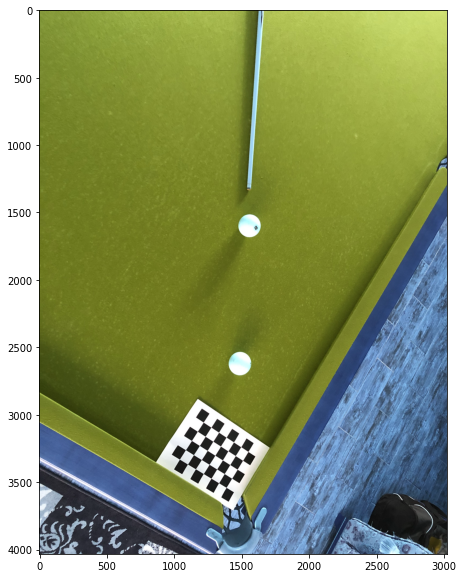

In [18]:
show_image(image=img_bgr, figsize=(10, 10)) # вывод изображения

In [19]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # конвертируем в другую цветовую схему (изначально картинка в формате BGR)
show_image(image=img_rgb, figsize=(10, 10)) # вывод изображения

In [20]:
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) # конвертируем в другую цветовую схему (изначально картинка в формате BGR)
show_image(image=img_gray, figsize=(10, 10), gray=True) # вывод изображения

## Нахождение шахматной сетки

In [21]:
ret, corners = cv2.findChessboardCorners(image=img_rgb, patternSize=(7,5), corners=None) # ищем углы шахматной доски (на чёрно-белом изображении)
# image — 8-bit grayscale или цветное изображение
# patternSize — количество внутренних углов у шахматной доски (за строку, за столбец) ~ (число строк доски -1, число столбцов доски -1)
# corners — выходной массив для обнаруженных углов (None, чтобы вернуть их как результат выполнения функции)

In [22]:
# вывод результата работы функции "findChessboardCorners" (найдена ли доска, координат внутренних углов у доски)
print(f"Найдена ли шахматная доска: {ret}.")
corners # np.array внутренних углов (координаты углов: сначала идёт ширина, а потом высота; однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!))

Найдена ли шахматная доска: True.


array([[[1219.4376, 3056.5808]],

       [[1277.0518, 3094.7585]],

       [[1333.8605, 3132.0178]],

       [[1390.2826, 3169.0957]],

       [[1444.555 , 3205.57  ]],

       [[1499.2079, 3239.8086]],

       [[1552.0151, 3275.3193]],

       [[1175.9465, 3125.195 ]],

       [[1234.6776, 3162.3206]],

       [[1291.4543, 3199.15  ]],

       [[1348.2926, 3235.7307]],

       [[1402.5997, 3270.6343]],

       [[1457.9357, 3306.1316]],

       [[1511.2125, 3340.624 ]],

       [[1131.752 , 3192.421 ]],

       [[1190.5787, 3230.497 ]],

       [[1249.0702, 3266.6582]],

       [[1305.579 , 3302.8232]],

       [[1362.2975, 3337.4644]],

       [[1417.0515, 3372.0532]],

       [[1472.4702, 3407.2898]],

       [[1088.1343, 3262.1582]],

       [[1148.1918, 3299.1729]],

       [[1206.2155, 3335.018 ]],

       [[1263.6313, 3370.5698]],

       [[1320.0679, 3404.9834]],

       [[1376.1384, 3439.2349]],

       [[1430.6465, 3473.2466]],

       [[1043.0817, 3331.5747]],

       [[1103.

In [23]:
img_rgb_corners = img_rgb.copy() # делаем копию, чтобы не испортить оригинал
img_rgb_corners = cv2.drawChessboardCorners(image=img_rgb_corners, patternSize=(7, 5), corners=corners, patternWasFound=ret) # добавляем сетку найденной шахматной доски на изображение
# image — изображение, на которое нужно добавить сетку шахматной доски (ОНО ПЕРЕЗАПИШЕТСЯ ВСЁ РАВНО!)
# patternSize — количество внутренних углов у шахматной доски (за строку, за столбец) ~ (число строк доски -1, число столбцов доски -1)
# corners — найденные внутренние углы
# patternWasFound — флаг, что углы уже найдены и переданы в corners

In [24]:
show_image(image=img_rgb_corners[2700:3800, 700:1800,], figsize=(10, 10)) # вывод изображения
# [2700:3800, 700:1800,] — срез пикселей (для приближения) по высоте от 2700 до 3800, по ширине от 700 до 1800, все 3 канала оставляем

## Получение "[вида сверху](https://digiratory.ru/1674)"

**Модель камеры:**

Матрицы ***P*** — проекционная матрица размерности *3x4*. Необходима для получения координат изображения в 2D из 3D проекции.

$$
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} 
= \mathbf{P} * \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} 
= \begin{bmatrix} p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \end{bmatrix} * \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} 
$$

Она имеет 11 степеней свободы, то есть $p_{34}$ = 1

Или более точная запись:

$$
s * \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} 
= \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix} * \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_1 \\ r_{21} & r_{22} & r_{23} & t_2 \\ r_{31} & r_{32} & r_{33} & t_3 \end{bmatrix} * \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} 
$$

где 
$$
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} \text{— 2D Image coordinates} 
\newline
\begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix} \text{— Intrinsic properties (Optical centre, scaling)} 
\newline
\begin{bmatrix} r_{11} & r_{12} & r_{13} & t_1 \\ r_{21} & r_{22} & r_{23} & t_2 \\ r_{31} & r_{32} & r_{33} & t_3 \end{bmatrix} \text{— Extrinsic properties (Camera rotation, Translation)} 
\newline
\begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} \text{— 3D World coordinates} 
$$

Откуда координаты изображения (пикселей) в 2D вычисляются следующим образом:
$$
x= \frac{p_{11}X + p_{12}Y + p_{13}Z + p_{14}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}
\newline
y= \frac{p_{21}X + p_{22}Y + p_{23}Z + p_{24}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}
$$

**Гомография:**

Работа с планарными (плоскими) объектами — часто возникающая задача в компьютерном зрении. 

Преобразования для планарных объектов называются **гомографией**. 

Два изображения одного и того же плоского объекта связаны **гомографией** — это преобразование ***H*** (матрица ***P*** в случае плоских изображений), отображающее точки одного изображения в точки другого изображения (***H*** трансформирует плоскость в плоскость).

$$
s * \begin{bmatrix} x^′ \\ y^′ \\ 1 \end{bmatrix} 
= \mathbf{H} * \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} 
= \begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{bmatrix} * \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$

К примеру есть плоский объект, расположенный в одной плоскости, который имеет точки *q1, q2, q3, q4*. Мы снимаем объект в одном положении с фиксированной камерой, после чего снимаем этот же объект в другом положении с той же камеры. Точка *q1* представляет одну и ту же точку на двух разных изображениях, также как и точки *q2, q3 и q4*. В компьютерном зрении такие точки называются **соответствующими точками**.

Координаты точек на первом и втором изображении будут связаны преобразованием *гомографии*:
$$
x^′= \frac{h_{11}x + h_{12}y + h_{13}}{h_{31}x + h_{32}y + h_{33}}
\newline
y^′= \frac{h_{21}x + h_{22}y + h_{23}}{h_{31}x + h_{32}y + h_{33}}
$$

Выведем это преобразование:

Рассмотрим проекцию на первом изображении и проекцию на втором изображении. Во втором случае у нас другая проекционная матрица, потому что поза другая, соответственно точка тоже будет другая. Мы хотим ***найти преобразование между пикселями на изображении***. Идея получения этого преобразования состоит в следующем: ***так как объект плоский, то мы можем выбрать такую систему координат, в которой начало координат расположено где-то на этой плоскости***, ось ***Z*** будет направлена по нормали к этой плоскости (оси ***X***, ***Y*** будут направлены как-то на плоскости). ***В этой системе координат будут новые проекционные матрицы, которые всегда можно пересчитать***.

Главное, что координаты нашего объекта теперь вместо ***(X,Y,Z,1)*** будут ***(X,Y,0,1)***. При умножении такого вектора ***(X,Y,0,1)*** на проекционную матрицу размерности *3×4*, то третий столбец будет все время умножаться на ноль. Поэтому на плоскости в качестве проекционной матрицы мы можем использовать матрицу ***P*** без третьего столбца и умножать ее на вектор ***(X,Y,1)***. Если домножим ещё на обратную матрицу ***s***, то получим (*X*~*x*, *Y*~*y* при переходе от трёхмерного в двумерное пространство):

$$
s * \begin{bmatrix} x^′ \\ y^′ \\ 1 \end{bmatrix} 
= \begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{bmatrix} * \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
= s* \begin{bmatrix} p_{11} & p_{12} & — & p_{14} \\ p_{21} & p_{22} & — & p_{24} \\ p_{31} & p_{32} & — & p_{34} \end{bmatrix} * \begin{bmatrix} X \\ Y \\ — \\ 1 \end{bmatrix} 
$$

Таким образом, если мы знаем координаты первого изображения на плоскости, то существует такая матрица размером *3×3*, с помощью которой можно найти координаты на втором изображении, используя формулу приведенную выше. Результатом такого преобразования получается вектор в однородных координатах. Для перехода от однородных координат к мировым нужно результирующий вектор поделить на **s**.

**Из этого следует, что для получения "вида сверху" достаточно взять 4 точки из найденной шахматной доски, например — самые угловые. Затем вручную задать (так как нет других изображений) их поворот, чтобы они выровнялись (не были наклонены). По подсчитанным вручную положениям углов шахматной доски (выравнена поворотом) посчитать гомогенную матрицу, что необходима для поворота изначального изображения.**

In [25]:
corners_supporting = np.array([corners[i][0] for i in [0, 6, 28, 34]]) # оставляем 4 опорных угла (точки) в виде np.array (shape = (4,2) вместо (4,1,2))
# их номера 0, 6, 28, 34, так как всего углов 35 (нумеруются с 0) и они идут вдоль какой-нибудь стороны (вдоль столбцов по строкам)

In [26]:
img_rgb_corners__supporting = img_rgb.copy() # делаем копию, чтобы не испортить оригинал
img_rgb_corners__supporting = cv2.drawChessboardCorners(image=img_rgb_corners__supporting, patternSize=(2, 2), corners=corners_supporting, patternWasFound=ret) # добавляем сетку найденной шахматной доски на изображение
# изменили patternSize на (2, 2), так как точек теперь 4

show_image(image=img_rgb_corners__supporting[2700:3800, 700:1800, :], figsize=(10, 10)) # вывод изображения
# [2700:3800, 700:1800, :] — срез пикселей (для приближения) по высоте от 2700 до 3800, по ширине от 700 до 1800, : — все 3 канала оставляем

Считаем расстояние между точками, чтобы узнать размер шахматной доски в писелях.

In [27]:
corners_supporting # координаты углов: сначала идёт ширина, а потом высота; однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!)

array([[1219.4376, 3056.5808],
       [1552.0151, 3275.3193],
       [1043.0817, 3331.5747],
       [1389.6381, 3540.387 ]], dtype=float32)

In [28]:
chess_height = cv2.norm(corners_supporting[0], corners_supporting[1]) # считаем норму (расстояние между точками) как высоту шахматной доски (точки 0 и 1)
chess_width = cv2.norm(corners_supporting[0], corners_supporting[2]) # считаем норму (расстояние между точками) как ширину шахматной доски (точка 0 и 2)

Задаём новую позицию для шахматной доски на изображении (пусть она будет в левом нижнем углу).

In [29]:
pad = 100 # размер отступа от края картинки (произвольный)
original_img_height = img_rgb.shape[0] # изначальная высота изображения (нужно так как ось OX идёт снизу вверх)

corners_new = np.array([[chess_width+pad, original_img_height - (chess_height+pad)], [chess_width+pad, original_img_height-pad], [pad, original_img_height - (chess_height+pad)], [pad, original_img_height-pad]], dtype=np.float32) # новое положение углов шахматной доски
corners_new # координаты новых углов: сначала идёт ширина, а потом высота; однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!)

array([[ 426.68497, 3533.9368 ],
       [ 426.68497, 3932.     ],
       [ 100.     , 3533.9368 ],
       [ 100.     , 3932.     ]], dtype=float32)

Трансформируем начальное изображение (получаем "вид сверху").

In [30]:
H = cv2.getPerspectiveTransform(corners_supporting, corners_new) # считаем матрицу гомографии
H

array([[ 4.10489753e-01, -7.00697079e-01,  1.98919603e+03],
       [ 2.78127675e-01,  3.55803712e-01,  1.45575204e+03],
       [-1.06244583e-04, -1.79258259e-05,  1.00000000e+00]])

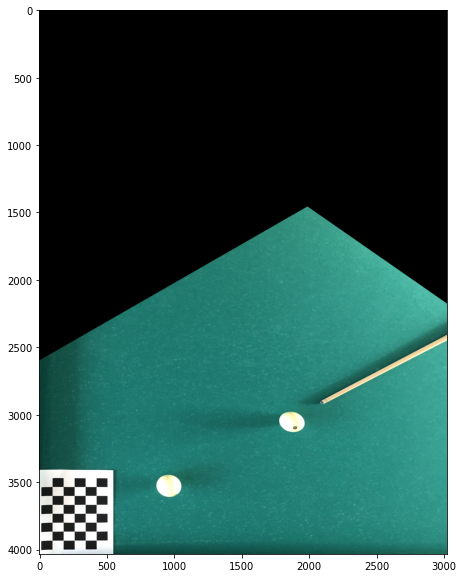

In [31]:
img_rgb_rotated = cv2.warpPerspective(img_rgb, H, dsize=(img_rgb.shape[1], img_rgb.shape[0])) # поворачиваем изначальное изображение с помощью гомографии
show_image(image=img_rgb_rotated, figsize=(10, 10)) # вывод изображения

Довольно большая часть (верх) картинки теперь не несёт информации, поэтому обрежем её.

New shape: (2532, 3024, 3)


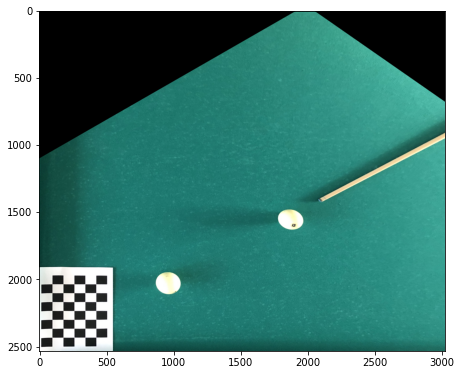

In [32]:
img_rgb_rotated = img_rgb_rotated[1500:, :, :] # [1500:, :, :] — срез пикселей по высоте от 1500 до низа изображения, по ширине и цветовым каналам всё остаётся как прежде
print(f"New shape: {img_rgb_rotated.shape}") # вывод размерности
show_image(image=img_rgb_rotated, figsize=(10, 6.25)) # вывод изображения

## Преобразования над изображением

Для поиска объектов на изображении проведём его трансформацию, схожую с той, что была в задании 2.

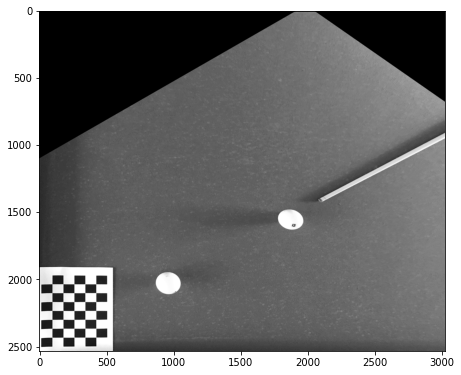

In [33]:
img_gray_rotated = cv2.cvtColor(img_rgb_rotated, cv2.COLOR_RGB2GRAY) # конвертируем из RGB в чёрно-белую цветовую схему (cv2.COLOR_RGB2GRAY)
show_image(image=img_gray_rotated, figsize=(10, 6.25), gray=True) # вывод изображения

Бинаризируем изображение для максимального контраста объектов (можно делать не только с чёрно-белыми картинками, но для контраста лучше именно с ними).

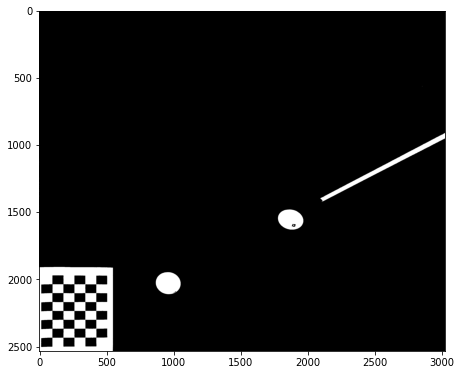

In [34]:
thresh, img_bin = cv2.threshold(img_gray_rotated, thresh=170, maxval=255, type=cv2.THRESH_BINARY) # бинаризируем изображение (type — тип бинаризации, при cv2.THRESH_BINARY: если значение пикселя больше thresh, то оно заменяется на maxval, иначе — 0)
show_image(image=img_bin, figsize=(10, 6.25), gray=True) # вывод изображения

Обрежем часть с шахматной доской, чтобы она не мешала при поиске линий.

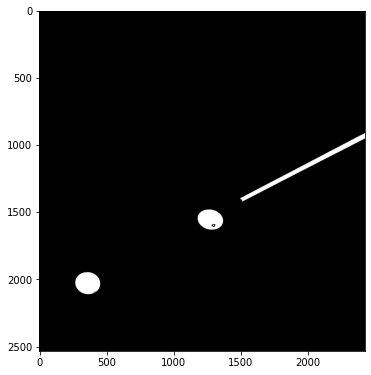

In [35]:
cut_length = 600 # число пикселей среза по горизонтали
img_bin = img_bin[:,cut_length:] # делаем срез пикселей по ширине (по высоте остаётся всё как было)
show_image(image=img_bin, figsize=(6.25, 6.25), gray=True) # вывод изображения

## Поиск кия (преобразование Хафа)

Теперь можно искать прямые линии (без блюра и алгоритма Кэнни, так как границы уже чёткие, но нужно будет выставить более жёсткие параметры).

In [36]:
lines = cv2.HoughLinesP(image=img_bin, rho=1, theta=np.pi/180, threshold=1000, minLineLength=920, maxLineGap=0) # поиск линий преобразованием Хафа
# image — одноканальное БИНАРНОЕ изображение (только два цвета — чёрный и белый)
# rho — разрешение сетки Хафа в пикселях (шаг в пикселях ~ изменение длины линий у гипотез) (distance resolution in pixels of the Hough grid)
# theta — угловое разрешение в радианах для сетки Хафа (на какой угол будут различаться гипотезы) (angular resolution in radians of the Hough grid)
# threshold — минимальное количество голосов для линии, чтобы она таковой считалась (сколько гипотез должно совпасть для линии)
# minLineLength — минимальное число пикселей в линии
# maxLineGap — максимальное число пикселей, что могут разделять одну линию

lines = lines.reshape(lines.shape[0], lines.shape[-1]) # убираем лишнии вложенности (num_lines, 1, 4) => (num_lines, 4)
lines # найденные линии (параметры подобраны специально, чтобы нашлось только две линии) 
# в формате (ширина точки 1, высота точки 1, ширина точки 2, высота точки 2) ~ (x1, y1, x2, y2) однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!)

array([[1502, 1401, 2423,  911]], dtype=int32)

In [37]:
img_res = img_rgb_rotated.copy() # делаем копию, чтобы не испортить оригинал
for line in lines: # идём по найденным линиям
    line[0] += cut_length # не забываем про то, что делали срез изображения по ширине, поэтому добавляем размер среза к координатам x
    line[2] += cut_length # не забываем про то, что делали срез изображения по ширине, поэтому добавляем размер среза к координатам x
    img_res = cv2.line(img=img_res, pt1=line[:2], pt2=line[2:4], color=(0,0,255), thickness=15) # добавляем линию на изображение 
    # img — изображение, на которое добавятся линии (будет перезаписано)
    # pt1 и pt2 — координаты начала и конца линии
    # color — цвет линии
    # thickness — толщина линии

show_image(image=img_res, figsize=(10, 6.25)) # вывод изображения

## Поиск шаров (преобразование Хафа)

In [38]:
circles = cv2.HoughCircles(image=img_bin, method=cv2.HOUGH_GRADIENT, dp=1, minDist=100, param1=20, param2=14, minRadius=70)
# image — одноканальное изображение (чёрно-белое)
# method — метод поиска окружностей
# dp — обратный коэффициент скалирования изображения по отношению к сетке Хафа (Inverse ratio of the accumulator resolution to the image resolution. For example, if dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has half as big width and height.)
# minDist — минимальное расстояние между центрами найденных окружностей
# param1 — First method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
# param2 — 	Second method-specific parameter. In case of HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
# minRadius — минимальный радиус окружности в пикселях

circles = circles.reshape(circles.shape[1], circles.shape[-1]) # убираем лишнюю размерность (1, num_circles, 3) => (num_circles, 3)
circles # найденные окружности в формате (ширина средней точки, высота средней точки, радиус) ~ (x, y, r) однако у рассматриваемого изображения сначала идёт высота, а потом ширина (важно не ошибиться!)

array([[ 376.5, 2028.5,   77.6],
       [1281.5, 1554.5,   74.8]], dtype=float32)

In [39]:
for circle in circles: # идём по найденным окружностям
    circle[0] += cut_length # добавляем отрезанный участок cut_length 
    x, y, radius = circle # берём данные об окружности
    center = np.array([x, y], dtype=np.int32) # конвертируем координаты в int
    radius = int(radius) # конвертируем радиус в int
    img_res = cv2.circle(img=img_res, center=center, radius=radius, color=(255,0,0), thickness=20) # добавляем точку на изображение
    # img — изображение, на которое добавится круг (будет перезаписано)
    # center — координаты центра добавляемой окружности
    # radius — радиус окружности в пикселях
    # color — цвет окружности
    # thickness — ширина линии окружности

show_image(image=img_res, figsize=(10, 6.25)) # вывод изображения

## Оценка направление удара и траектории прицельного шара после удара

Посчитаем, куда сместиться центр первого шара после удара по нему.

In [40]:
circle_prime = circles[1] # шар, по которому бьют ~ биток (он идёт как вторая окружность)
radius_prime = int(circle_prime[2]) # радиус шара, по которому бьют

circle_second = circles[0] # прицельный шар, что должен будет отскочить от первого
radius_second = int(circle_second[2]) # радиус прицельного шара
center_second = circle_second[:2].astype(np.int32) # центр как int
center_second[0] -= cut_length # делаем смещение по оси OX из-за среза (чтобы теперь подходило под бинарное изображение, далее в коде этот срез ревертнётся)

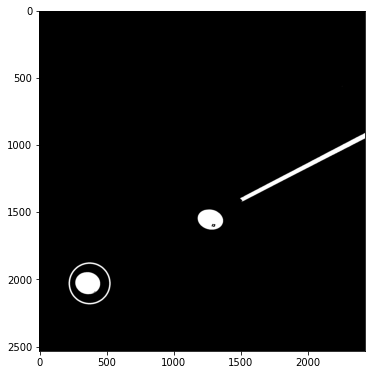

In [41]:
radius_double = radius_prime + radius_second # добавим к радиусу прицельного шара радиус битка (так как мы будем работать с центрами) и сконвертируем в int

img_bin = cv2.circle(img=img_bin, center=center_second, radius=radius_double, color=(255,0,0), thickness=10) # добавляем окружность на бинарное изображение
show_image(image=img_bin, figsize=(6.25, 6.25), gray=True) # вывод изображения
# дополнительная окружность — возможные положения цента битка при соприкосновении

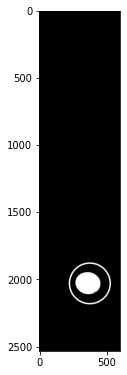

In [42]:
show_image(image=img_bin[:, :600], figsize=(6.25, 6.25), gray=True) # вывод области со прицельным шаром, в ней будет поиск "граничных" (останавливающих) пикселей для битка

In [43]:
line = lines[0] # линия, отвечающая за кий
x_diff = line[0] - line[2] # разница крайних точек по оси OX
y_diff = line[1] - line[3] # разница крайних точек по оси OY
vx, vy = np.array([x_diff, y_diff]) / max(abs(x_diff), abs(y_diff)) # считаем "скорость" изменения от древка кия до его кончика (то есть делим разницу расстояний на модуль максимальной разницы, чтобы нормализировать и "скорости" были в диапазоне от -1 до 1)
print(f"vx: {vx}, vy: {vy:.4f}") # вывод "скоростей"

# задаём дополнительную "границу" (пиксели, на которых остановится биток) как точки у прицельного шара
y_border, x_border = np.where(img_bin[:, :600] == 255) # получение координат у прицельного шара (срез [:, :600] влияет только на ширину, при этом координаты пересчитывать не надо)
x_border += cut_length # добавляем отрезанный участок cut_length 
borders = [] # заготовка под координаты пикселей, что будут "границами"
for i in range(x_border.shape[0]): # идём по числу точек прицельного шара
    borders.append([x_border[i], y_border[i]]) # объединяем координаты


new_center = movement(circle_prime, vx, vy, xmax=img_res.shape[1], ymax=img_res.shape[0], borders=borders) # смещаем центр как от удара
img_res = cv2.circle(img=img_res, center=new_center, radius=radius_prime, color=(255,145,0), thickness=20) # добавляем окружность (новая позиция битка) на изображение
# img — изображение, на которое добавится круг (будет перезаписано)
# center — координаты центра добавляемой окружности
# radius — радиус окружности в пикселях
# color — цвет окружности
# thickness — ширина линии окружности

show_image(image=img_res, figsize=(10, 6.25)) # вывод изображения

vx: -1.0, vy: 0.5320


Рассчитаем, куда отправится прицельный шар, когда его коснётся биток. 

В максимально упрошённом варианте сначала нужно найти точку соприкосновения шаров (окружностей), после чего отправить прицельный шар в противоположную от точки соприкосновения сторону (считаем, что энергия не уменьшается и передастся полностью).

In [44]:
circle_prime = np.array([new_center[0], new_center[1], radius_prime], dtype=np.int32) # новые данные, описывающие биток
circle_second = circle_second.astype(np.int32) # данные для прицельного шара не изменились, просто сконвертируем их тоже в int
print(f"Биток: x={circle_prime[0]}, y={circle_prime[1]}, radius={circle_prime[2]}") 
print(f"Прицельный шар: x={circle_second[0]}, y={circle_second[1]}, radius={circle_second[2]}") 

Биток: x=1117, y=1960, radius=74
Прицельный шар: x=976, y=2028, radius=77


Так как шары "коснулись" друг друга, то направление полёта прицельного шара можно вычислись используя центры обоих шаров (построить по ним прямую, в простейшем случае — не учитывая инерцию, с полной передачей энергии и небольшим принебреганием угла соприкосновения).

In [45]:
line_coefs = line_equation(pt1=circle_prime[:2], pt2=circle_second[:2]) # находим уравнение прямой, проходящей через две точки (центры шаров)
line_coefs # коэффициент "a" и смещение "b" для уравнения y=a*x+b

[-0.48226950354609927, 2498.695035460993]

Пусть траектория будет до точки, когда x=0.

In [46]:
end_point = get_line_point(0, *line_coefs) # считаем значение y при x=0 с использованием полученного уравнения прямой line_coefs
end_point = np.array(end_point, dtype=np.int32) # конвертируем точку в np.array типа int
end_point

array([   0, 2498])

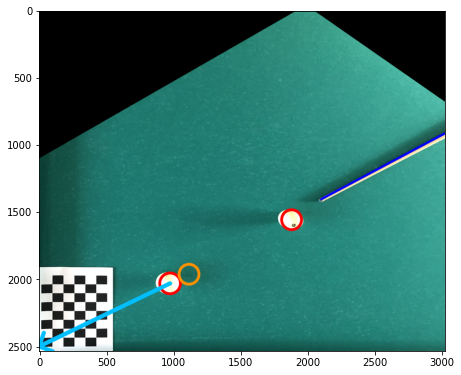

In [47]:
img_res = cv2.arrowedLine(img=img_res, pt1=circle_second[:2], pt2=end_point, color=(0, 191, 255), thickness=30) # добавляем стрелку на изображение 
# img — изображение, на которое добавятся линии (будет перезаписано)
# pt1 и pt2 — координаты начала и конца линии
# color — цвет линии
# thickness — толщина линии

show_image(image=img_res, figsize=(10, 6.25)) # вывод изображения

Пример, если бы центр битка был в другом месте (на изображении показан ярко-зелёного цвета).

Новый биток: x=1000, y=1860, radius=74
Прицельный шар: x=976, y=2028, radius=77


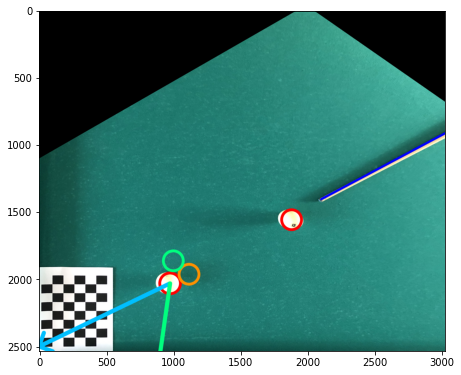

In [48]:
circle_example = np.array([1000, 1860, radius_prime], dtype=np.int32) # новые данные, описывающие биток
print(f"Новый биток: x={circle_example[0]}, y={circle_example[1]}, radius={circle_example[2]}") 
print(f"Прицельный шар: x={circle_second[0]}, y={circle_second[1]}, radius={circle_second[2]}")

line_coefs_example = line_equation(pt1=circle_example[:2], pt2=circle_second[:2]) # находим уравнение прямой, проходящей через две точки (центры шаров)

end_point_example = get_line_point(0, *line_coefs_example) # считаем значение y при x=0 с использованием полученного уравнения прямой line_coefs
end_point_example = np.array(end_point_example, dtype=np.int32) # конвертируем её в np.array типа int

img_res_example = img_res.copy() # делаем копию, чтобы не испортить оригинал
img_res_example = cv2.circle(img=img_res_example, center=circle_example[:2], radius=circle_example[2], color=(0,255,127), thickness=20) # добавляем окружность (новая позиция битка) на изображение
img_res_example = cv2.arrowedLine(img=img_res_example, pt1=circle_second[:2], pt2=end_point_example, color=(0,255,127), thickness=30) # добавляем стрелку на изображение 
show_image(image=img_res_example, figsize=(10, 6.25)) # вывод изображения